# Librerias

In [1]:
import os
import zipfile

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import string

import tensorflow as tf
import logging

# Establece el nivel de log de TensorFlow a 'ERROR'
tf.get_logger().setLevel('ERROR')

# Si utilizas XLA, puedes ajustar el nivel de log de XLA también
tf.debugging.set_log_device_placement(False)

def check_gpu():
    # Verifica si TensorFlow puede detectar GPUs
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        print("TensorFlow detectó las siguientes GPUs:")
        for gpu in gpus:
            print(f"- {gpu.name}")
            # Obtiene información adicional sobre la GPU
            details = tf.config.experimental.get_device_details(gpu)
            print(f"  - Nombre: {details.get('device_name', 'Desconocido')}")
    else:
        print("No se detectaron GPUs. Verifica la configuración de CUDA y cuDNN.")

if __name__ == "__main__":
    check_gpu()

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout, Activation, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow import keras
import kerastuner as kt

2024-08-16 20:54:35.742997: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-16 20:54:35.804525: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-16 20:54:35.823759: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-16 20:54:35.936745: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-16 20:54:36.960656: W tensorflow/compiler/tf2

TensorFlow detectó las siguientes GPUs:
- /physical_device:GPU:0
  - Nombre: NVIDIA GeForce RTX 4060 Laptop GPU


/tmp/ipykernel_53843/1321040727.py:43: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


# Datos

In [2]:
!wget --no-check-certificate https://storage.googleapis.com/platzi-tf2/sign-language-img.zip -O /tmp/sign-language-img.zip

--2024-08-16 20:54:38--  https://storage.googleapis.com/platzi-tf2/sign-language-img.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.135.187, 172.217.28.123, 172.217.172.27, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.135.187|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24265584 (23M) [application/zip]
Saving to: ‘/tmp/sign-language-img.zip’

/tmp/sign-language- 100%[===================>]  23.14M  7.78MB/s    in 3.0s    

2024-08-16 20:54:41 (7.78 MB/s) - ‘/tmp/sign-language-img.zip’ saved [24265584/24265584]



Found 27455 images belonging to 24 classes.
Found 1425 images belonging to 24 classes.
Found 7172 images belonging to 24 classes.


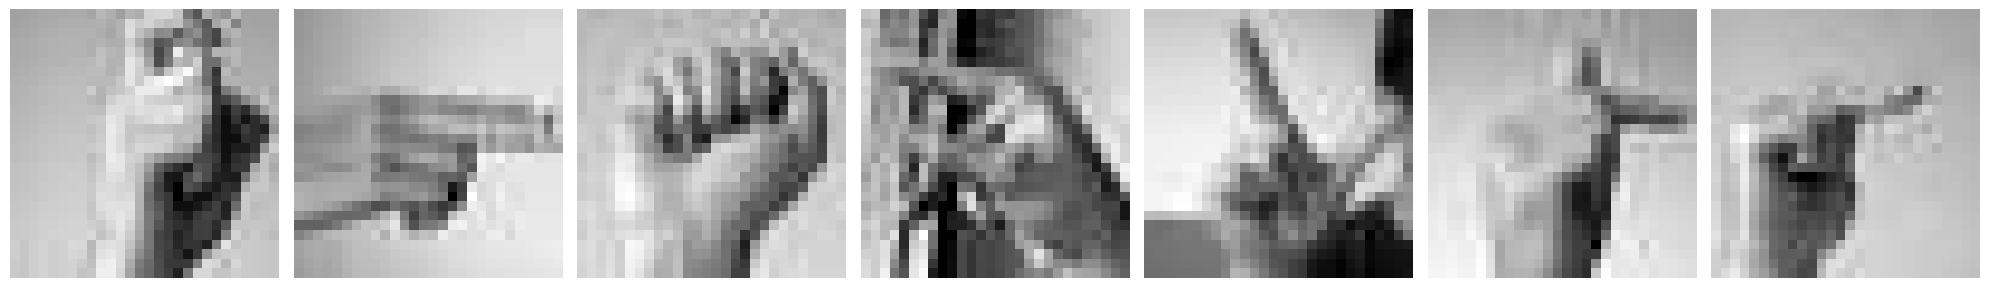

In [3]:
local_zip = '/tmp/sign-language-img.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/sign-language-img')
zip_ref.close()

train_dir = '/tmp/sign-language-img/Train'
test_dir = '/tmp/sign-language-img/Test'

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(28, 28),
    batch_size=128,
    class_mode='categorical',
    color_mode='grayscale'
)

validation_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(28, 28),
    batch_size=128,
    class_mode='categorical',
    color_mode='grayscale',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(28, 28),
    batch_size=128,
    class_mode='categorical',
    color_mode='grayscale'
)

def PlotImages(images_arr):
    fig, axes = plt.subplots(1, 7, figsize=(20, 20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img[:, :, 0], cmap='gray')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

sample_training_images, _ = next(train_generator)
PlotImages(sample_training_images[:7])


# Modelo

In [4]:
def visualizacion_resultados(hist, epochs):
    
    train_acc = hist.history['accuracy']
    val_acc = hist.history['val_accuracy']
    train_loss = hist.history['loss']
    val_loss = hist.history['val_loss']
    
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].plot(range(epochs), train_acc, label='Train Accuracy')
    ax[0].plot(range(epochs), val_acc, label='Validation Accuracy')
    ax[0].set_title('Accuracy')
    ax[0].legend()
    ax[1].plot(range(epochs), train_loss, label='Train Loss')
    ax[1].plot(range(epochs), val_loss, label='Validation Loss')
    ax[1].set_title('Loss')
    ax[1].legend()

I0000 00:00:1723859684.982586   53843 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1723859684.982877   53843 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1723859684.983064   53843 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1723859685.053446   53843 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 24)             │       301,080 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 320,280 (1.22 MB)

 Trainable params: 320,088 (1.22 MB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/3


/home/riemannintegrable/anaconda3/envs/dsenv/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1723859686.210724   55018 service.cc:146] XLA service 0x765a980044d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1723859686.210759   55018 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2024-08-16 20:54:46.257893: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-16 20:54:46.433886: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded 

 14/215 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.2358 - loss: 3.7692

I0000 00:00:1723859689.446114   55018 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


209/215 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7853 - loss: 0.9473
Epoch 1: val_accuracy improved from -inf to 0.09193, saving model to godin.weights.h5
215/215 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - accuracy: 0.7901 - loss: 0.9259 - val_accuracy: 0.0919 - val_loss: 3.5395
Epoch 2/3
207/215 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 0.0101
Epoch 2: val_accuracy improved from 0.09193 to 0.65965, saving model to godin.weights.h5
215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 1.0000 - loss: 0.0101 - val_accuracy: 0.6596 - val_loss: 1.1523
Epoch 3/3
207/215 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 0.0084
Epoch 3: val_accuracy improved from 0.65965 to 0.85544, saving model to godin.weights.h5
215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 1.0000 - loss: 0.0084 - val_accuracy: 0.8554 - val_loss: 0.5305
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8586 - loss: 0.5087


[0.5280365347862244, 0.8537367582321167]

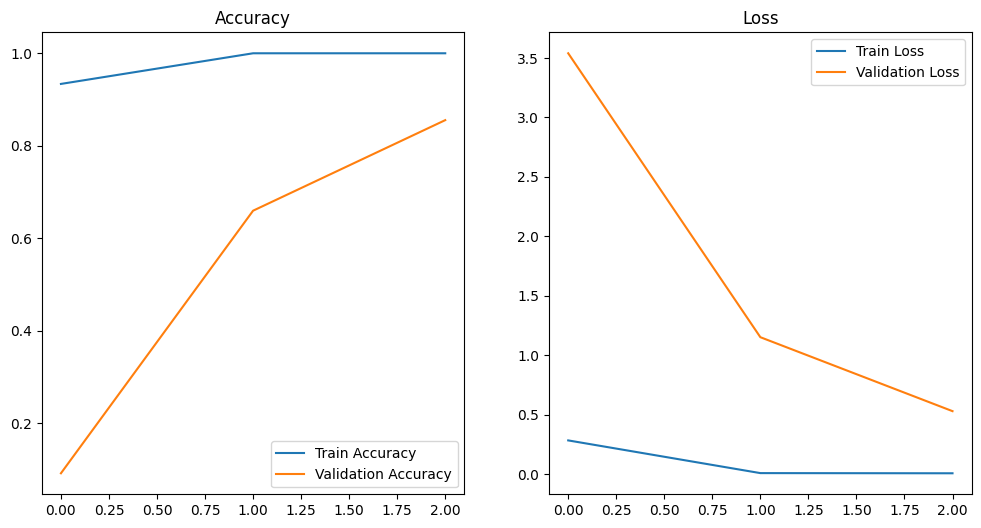

In [5]:
early = EarlyStopping(monitor='val_accuracy', patience=4)
mejor = ModelCheckpoint('godin.weights.h5', save_best_only=True, save_weights_only=True, monitor='val_accuracy', mode='max', verbose=1)

# Creando modelo 3
modelo_3 = tf.keras.models.Sequential()

# Añadir la primera capa convolucional
modelo_3.add(Conv2D(32, kernel_size=(3,3), padding='same', kernel_regularizer=regularizers.l1(1e-5), input_shape=(28,28,1)))
modelo_3.add(Activation('relu'))
modelo_3.add(BatchNormalization())

# Añadir la segunda capa convolucional
modelo_3.add(Conv2D(64, kernel_size=(3,3), padding='same', kernel_regularizer=regularizers.l1(1e-5)))
modelo_3.add(Activation('relu'))
modelo_3.add(MaxPooling2D(pool_size=(2,2)))
modelo_3.add(BatchNormalization())

# Añadir la capa de Flatten 
modelo_3.add(Flatten())
modelo_3.add(Dense(24, activation='softmax'))

modelo_3.summary()

modelo_3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

hist_3 = modelo_3.fit(train_generator, batch_size=512, epochs=3, validation_data=validation_generator, callbacks=[early, mejor])

visualizacion_resultados(hist_3, len(hist_3.epoch))

modeo_3 = modelo_3.load_weights('godin.weights.h5')

modelo_3.evaluate(test_generator)

# Con Keras Tuner

In [7]:
classes = [char for char in string.ascii_uppercase if char not in ['J', 'Z']]

In [6]:
def constructor_modelos(hp):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv2D(75, (3,3), activation= "relu", input_shape = (28, 28, 1)))
    model.add(tf.keras.layers.MaxPool2D((2,2)))
    model.add(tf.keras.layers.Flatten())

    hp_units = hp.Int("units", min_value = 32, max_value = 512, step = 32)
    model.add(tf.keras.layers.Dense(units=hp_units,activation = "relu", kernel_regularizer= regularizers.l2(1e-5)))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(128,activation = "relu", kernel_regularizer= regularizers.l2(1e-5)))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(len(classes), activation = "softmax"))

    hp_learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4])

    model.compile(optimizer = keras.optimizers.Adam(learning_rate=hp_learning_rate),loss = "categorical_crossentropy", metrics = ["accuracy"])

    return model

In [8]:
tuner = kt.Hyperband(
    constructor_modelos,
    objective="val_accuracy",
    max_epochs=30,
    factor=3,
    directory='models/',
    project_name='modelito'
)

/home/riemannintegrable/anaconda3/envs/dsenv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [9]:
tuner.search(train_generator, validation_data=validation_generator, epochs=30, callbacks=[early])

best_params = tuner.get_best_hyperparameters(num_trials=3)[0]

Trial 64 Complete [00h 00m 16s]
val_accuracy: 0.8456140160560608

Best val_accuracy So Far: 0.8891227841377258
Total elapsed time: 00h 14m 29s


In [10]:
best_params.values

{'units': 480,
 'learning_rate': 0.001,
 'tuner/epochs': 30,
 'tuner/initial_epoch': 10,
 'tuner/bracket': 3,
 'tuner/round': 3,
 'tuner/trial_id': '0046'}

In [13]:
modelardo = tuner.hypermodel.build(best_params)

hist_modelardo = modelardo.fit(train_generator, validation_data=validation_generator, epochs=30, callbacks=[early, mejor])

Epoch 1/30


/home/riemannintegrable/anaconda3/envs/dsenv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


209/215 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2994 - loss: 2.3971
Epoch 1: val_accuracy did not improve from 0.87018
215/215 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.3073 - loss: 2.3695 - val_accuracy: 0.7867 - val_loss: 0.6941
Epoch 2/30
207/215 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8964 - loss: 0.3629
Epoch 2: val_accuracy did not improve from 0.87018
215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8977 - loss: 0.3590 - val_accuracy: 0.8232 - val_loss: 0.6019
Epoch 3/30
214/215 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9775 - loss: 0.1184
Epoch 3: val_accuracy did not improve from 0.87018
215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9775 - loss: 0.1182 - val_accuracy: 0.8463 - val_loss: 0.6102
Epoch 4/30
214/215 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9907 - loss: 0.0697
Epoch 4: val_accuracy did not improve from 0.87018
215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9907 - loss: 0.0697 - val_accuracy: 0.8442 - val_

In [14]:
modelardo.load_weights('godin.weights.h5')

modelardo.evaluate(test_generator)

57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.8774 - loss: 0.5508


[0.5606777667999268, 0.8740937113761902]

In [17]:
modelardo.save("./modelardo.keras")

In [18]:
config_dict = modelardo.get_config()
print(config_dict)

{'name': 'sequential_2', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_shape': (None, 28, 28, 1), 'dtype': 'float32', 'sparse': False, 'name': 'input_layer_2'}, 'registered_name': None}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_2', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'filters': 75, 'kernel_size': (3, 3), 'strides': (1, 1), 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': (1, 1), 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registere

In [19]:
modelardo_mostrar = tf.keras.Sequential.from_config(config_dict)
modelardo_mostrar.summary() 

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 26, 26, 75)     │           750 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 13, 13, 75)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 12675)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 480)            │     6,084,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 480)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │        61,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 24)             │         3,096 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,149,894 (23.46 MB)

 Trainable params: 6,149,894 (23.46 MB)

 Non-trainable params: 0 (0.00 B)